In [55]:
# Setting up packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from styles.colors import get_colors
from scipy import stats
import re
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# Colors
ARDS_COLORS = get_colors("ards")
COLOR = get_colors("palette")
COLORS_SEQUENTIAL_TEAL = get_colors("sequential_teal")
COLORS_SEQUENTIAL_ORANGE = get_colors("sequential_orange")

# Clean data

In [39]:
data = pd.read_csv("data/processed/filtered_data.csv", index_col=0)
data.info()

/var/folders/rz/3cfhhdrd2bs65msqx2gtqcph0000gn/T/ipykernel_29067/2886768691.py:1: DtypeWarning: Columns (0: ards_notmild, 1: age) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/processed/filtered_data.csv", index_col=0)


<class 'pandas.DataFrame'>
Index: 408 entries, PLT36510 to PLT36539
Columns: 10830 entries, PlateRunDate to saps3_emr_swe
dtypes: bool(9), float64(10799), int64(6), object(1), str(15)
memory usage: 33.7+ MB


# Train + balanced validation test + test data, 

In [44]:
# --- setup ---
test_size = 0.05
val_frac_of_remaining = 0.20
random_state = 42

X = data.drop(columns=["ards"]).copy()
y = data["ards"].astype(int).copy()

# skapa unikt rad-id
row_id = np.arange(len(data))

# 5% test (stratified)
X_rem, X_test, y_rem, y_test, id_rem, id_test = train_test_split(
    X, y, row_id,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

rem_df = X_rem.copy()
rem_df["ards"] = y_rem
rem_df["row_id"] = id_rem

df_pos = rem_df[rem_df["ards"] == 1]
df_neg = rem_df[rem_df["ards"] == 0]

n_val_total = int(round(len(rem_df) * val_frac_of_remaining))
n_each = min(n_val_total // 2, len(df_pos), len(df_neg))

val_pos = df_pos.sample(n=n_each, random_state=random_state)
val_neg = df_neg.sample(n=n_each, random_state=random_state)

val_df = pd.concat([val_pos, val_neg]).sample(frac=1, random_state=random_state)

# split via row_id (inte index)
val_ids = set(val_df["row_id"].values)
train_df = rem_df[~rem_df["row_id"].isin(val_ids)]

X_val = val_df.drop(columns=["ards", "row_id"])
y_val = val_df["ards"]

X_train = train_df.drop(columns=["ards", "row_id"])
y_train = train_df["ards"]

# --- prints ---
def counts(y_):
    return len(y_), int(y_.sum()), int((1 - y_).sum())

for name, ys in [("train", y_train), ("val", y_val), ("test", y_test)]:
    n, n_pos, n_neg = counts(ys)
    print(f"{name:5s}: {n:4d} patients | ARDS: {n_pos:4d} | non-ARDS: {n_neg:4d}")

print("\nFractions:")
print(f"test: {len(y_test)/len(y):.3f}")
print(f"val : {len(y_val)/len(y):.3f}")
print(f"train: {len(y_train)/len(y):.3f}")


train:  311 patients | ARDS:   24 | non-ARDS:  287
val  :   76 patients | ARDS:   38 | non-ARDS:   38
test :   21 patients | ARDS:    3 | non-ARDS:   18

Fractions:
test: 0.051
val : 0.186
train: 0.762


# T-tests

In [45]:
# -----------------------------
# T-tests på träningsdatan (train-only)
# -----------------------------
protein_cols = [c for c in X_train.columns if re.match(r"^seq", str(c))]

rows = []
mask1 = (y_train == 1)   # ARDS
mask0 = (y_train == 0)   # non-ARDS

for prot in protein_cols:
    g1 = pd.to_numeric(X_train.loc[mask1, prot], errors="coerce")
    g0 = pd.to_numeric(X_train.loc[mask0, prot], errors="coerce")

    # drop NaNs for sanity checks + mean diff
    g1_clean = g1.dropna()
    g0_clean = g0.dropna()

    # need at least 2 values per group for a stable t-test
    if (len(g1_clean) < 2) or (len(g0_clean) < 2):
        continue

    mean_diff = g1_clean.mean() - g0_clean.mean()

    try:
        t = stats.ttest_ind(
            g1_clean.values, g0_clean.values,
            equal_var=False
        )
        pval = float(t.pvalue)
    except Exception:
        pval = np.nan

    if np.isfinite(pval):
        rows.append({
            "Protein": prot,
            "MeanDiff": mean_diff,
            "pval": pval,
            "n_ards": len(g1_clean),
            "n_non_ards": len(g0_clean),
        })

results = pd.DataFrame(rows)

# -----------------------------
# Multiple testing correction (train-only)
# -----------------------------
CORRECTION_METHOD = "fdr"  # "fdr" or "bonferroni"

method_map = {"fdr": "fdr_bh", "bonferroni": "bonferroni"}
mt_method = method_map.get(CORRECTION_METHOD.lower())
if mt_method is None:
    raise ValueError('CORRECTION_METHOD must be "fdr" or "bonferroni"')

_, adj_p, _, _ = multipletests(results["pval"].values, method=mt_method)
results["ADJ_P"] = adj_p

# optional: sort
results = results.sort_values(["ADJ_P", "pval"], ascending=True).reset_index(drop=True)

In [46]:
print("Train class counts:", int((y_train==1).sum()), "ARDS /", int((y_train==0).sum()), "non-ARDS")
print("Num proteins tested:", len(results))
display(results.head(10))


Train class counts: 24 ARDS / 287 non-ARDS
Num proteins tested: 10776


,Protein,MeanDiff,pval,n_ards,n_non_ards,ADJ_P
0,seq.28438.29,-0.068665,0.000001,24,287,0.010413
1,seq.33381.1,-0.062117,0.000003,24,287,0.010413
2,seq.15515.2,0.264466,0.000003,24,287,0.010413
3,seq.34586.36,-0.068525,0.000007,24,287,0.019203
4,seq.25066.32,-0.053343,0.000009,24,287,0.020038
5,seq.21942.14,-0.053021,0.000017,24,287,0.021796
6,seq.23224.11,-0.078180,0.000017,24,287,0.021796
7,seq.30466.5,-0.034204,0.000017,24,287,0.021796
8,seq.4282.3,0.188848,0.000018,24,287,0.021796
9,seq.4322.28,-0.053148,0.000023,24,287,0.024677


In [47]:
ANNOT_PATH = "Attilas/somalogic_annotation.csv"  # e.g. "somalogic_annotation.csv"

# -----------------------------
# Fix PROBEID format (dot to dash), strip leading "seq."
# R: gsub("^seq\\.", "", Protein) then replace "123.45" -> "123-45"
# We'll do: remove leading "seq." OR "seq" then convert the first "digits.digits" to "digits-digits"
# -----------------------------
def protein_to_probeid(name: str) -> str:
    s = str(name)
    s = re.sub(r"^seq\.", "", s)
    s = re.sub(r"^seq", "", s)
    # Replace first occurrence of digits.digits with digits-digits
    s = re.sub(r"([0-9]+)\.([0-9]+)", r"\1-\2", s)
    return s

results["PROBEID"] = results["Protein"].map(protein_to_probeid)

# -----------------------------
# SomaScan Annotation (Python replacement)
# -----------------------------
if ANNOT_PATH is not None:
    annot = pd.read_csv(ANNOT_PATH)
    # Expect columns: PROBEID, SYMBOL, UNIPROT, GENENAME (case-sensitive here; adjust if needed)
    for col in ["PROBEID", "SYMBOL", "UNIPROT", "GENENAME"]:
        if col in annot.columns:
            annot[col] = annot[col].astype(str).replace({"nan": ""})
else:
    # No annotation provided; create empty columns so later code works
    annot = pd.DataFrame({"PROBEID": results["PROBEID"].unique()})
    annot["SYMBOL"] = ""
    annot["UNIPROT"] = ""
    annot["GENENAME"] = ""

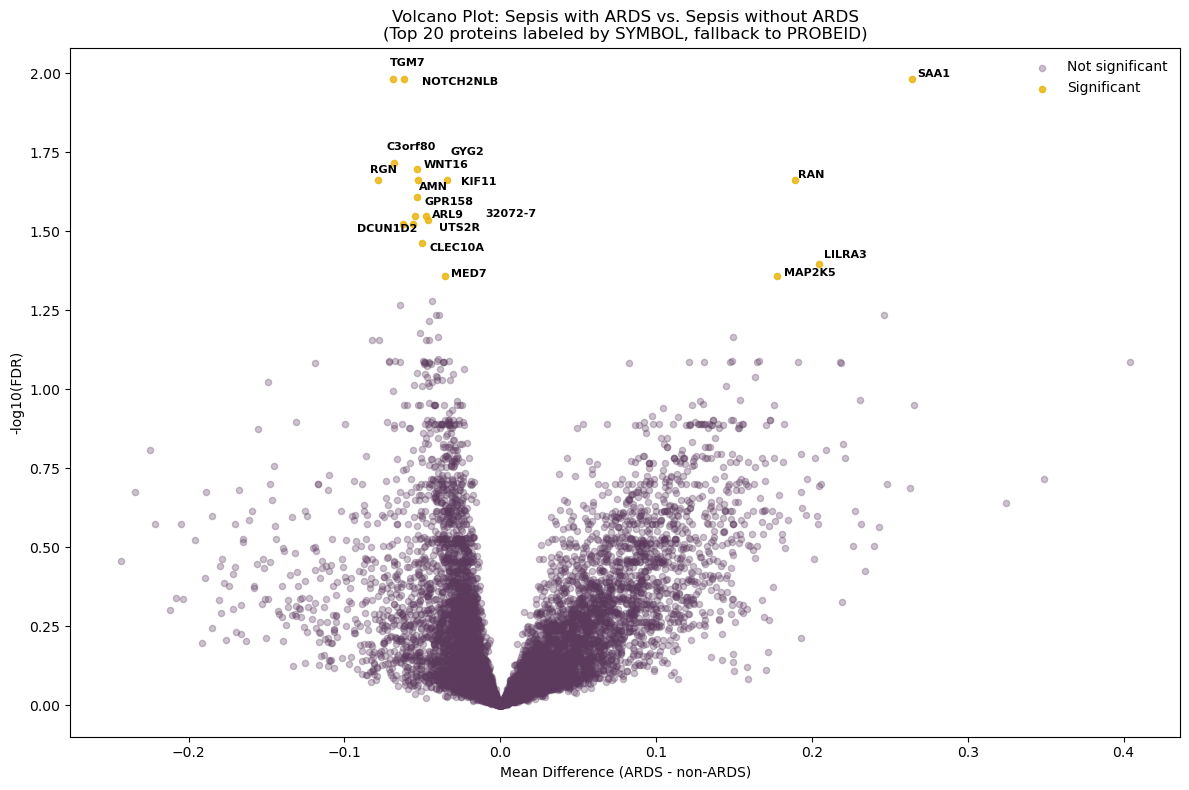

In [48]:
# Volcano plot
ALPHA_LABEL = 0.05
N_LABELS = 20

# -----------------------------
# Merge + deduplicate by Protein
# -----------------------------
volcano = results.merge(annot, on="PROBEID", how="left")

# Deduplicate by Protein (keep first)
volcano = volcano.drop_duplicates(subset=["Protein"]).reset_index(drop=True)

# Label: SYMBOL fallback to PROBEID
volcano["Label"] = np.where(
    volcano["SYMBOL"].notna() & (volcano["SYMBOL"].astype(str).str.strip() != "") & (volcano["SYMBOL"] != "nan"),
    volcano["SYMBOL"].astype(str),
    volcano["PROBEID"].astype(str),
)

# -----------------------------
# Top hits for labeling
# -----------------------------
sig_mask = volcano["ADJ_P"] < ALPHA_LABEL
top_hits = volcano.loc[sig_mask].copy()
if len(top_hits) > 0:
    top_hits = top_hits.sort_values("ADJ_P").head(N_LABELS)
else:
    top_hits = volcano.sort_values("ADJ_P").head(N_LABELS)

top_hits["Label"] = np.where(
    top_hits["SYMBOL"].notna() & (top_hits["SYMBOL"].astype(str).str.strip() != "") & (top_hits["SYMBOL"] != "nan"),
    top_hits["SYMBOL"].astype(str),
    top_hits["PROBEID"].astype(str),
)

# -----------------------------
# Volcano Plot (matplotlib + adjustText ~ ggrepel)
# -----------------------------
x = volcano["MeanDiff"].values
y = -np.log10(np.clip(volcano["ADJ_P"].values, 1e-300, 1.0))  # avoid log(0)

is_sig = volcano["ADJ_P"].values < ALPHA_LABEL

plt.figure(figsize=(12, 8))
plt.scatter(x[~is_sig], y[~is_sig], alpha=0.3, s=20, label="Not significant", color=COLOR['accent'])
plt.scatter(x[is_sig], y[is_sig], alpha=0.82, s=20, label="Significant", color = COLOR['warning'])

# Label points for top hits
texts = []
for _, r in top_hits.iterrows():
    tx = float(r["MeanDiff"])
    ty = -np.log10(max(float(r["ADJ_P"]), 1e-300))
    texts.append(plt.text(tx, ty, str(r["Label"]), fontsize=8, fontweight="bold"))

# Repel labels
adjust_text(texts)

y_label = "-log10(FDR)" if CORRECTION_METHOD.lower() == "fdr" else "-log10(Bonferroni adj. p)"
plt.xlabel("Mean Difference (ARDS - non-ARDS)")
plt.ylabel(y_label)
plt.title(
    f"Volcano Plot: Sepsis with ARDS vs. Sepsis without ARDS\n"
    f"(Top {N_LABELS} proteins labeled by SYMBOL, fallback to PROBEID)"
)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

In [49]:
sum(is_sig)

19

In [50]:
# List of the most significant according to adjusted p-value
top_significant = volcano.sort_values("ADJ_P").head(20)
print(top_significant[["PROBEID", "SYMBOL", "MeanDiff", "ADJ_P"]])

     PROBEID     SYMBOL  MeanDiff     ADJ_P
0   28438-29       TGM7 -0.068665  0.010413
1    33381-1  NOTCH2NLB -0.062117  0.010413
2    15515-2       SAA1  0.264466  0.010413
3   34586-36    C3orf80 -0.068525  0.019203
4   25066-32       GYG2 -0.053343  0.020038
5   21942-14      WNT16 -0.053021  0.021796
6   23224-11        RGN -0.078180  0.021796
7    30466-5      KIF11 -0.034204  0.021796
8     4282-3        RAN  0.188848  0.021796
9    4322-28        AMN -0.053148  0.024677
10  29432-44     GPR158 -0.054964  0.028291
11   18416-3       ARL9 -0.047881  0.028310
12   32072-7        NaN -0.046405  0.029185
13   19511-8    DCUN1D2 -0.062389  0.029892
14   13530-5      UTS2R -0.055898  0.029892
15   10955-4    CLEC10A -0.050538  0.034405
16   29497-3     LILRA3  0.204450  0.040094
17  22041-26     MAP2K5  0.177308  0.043633
18  30980-32       MED7 -0.035432  0.043633
19   7920-30    ST8SIA2 -0.043983  0.052422


# Klassificerare 

In [51]:
k = 10

# after computing results from TRAIN only
topk = results.sort_values("ADJ_P").head(k)["Protein"].tolist()

X_train_k = X_train[topk]
X_val_k   = X_val[topk]
X_test_k  = X_test[topk]
print(X_train_k.shape, X_val_k.shape, X_test_k.shape)


(311, 10) (76, 10) (21, 10)


In [52]:
# Train/test split 
print(X_train_k.shape, X_val_k.shape, X_test_k.shape, y_train.shape, y_val.shape, y_test.shape)
print(y_train.value_counts(), y_val.value_counts(), y_test.value_counts())


(311, 10) (76, 10) (21, 10) (311,) (76,) (21,)
ards
0    287
1     24
Name: count, dtype: int64 ards
1    38
0    38
Name: count, dtype: int64 ards
0    18
1     3
Name: count, dtype: int64


## Logistisk regression

In [66]:
# 1) Kombinera train + val
X_tv = pd.concat([X_train_k, X_val_k], axis=0)
y_tv = pd.concat([y_train,   y_val],   axis=0)

# 2) PredefinedSplit: -1 = alltid train, 0 = val-fold
test_fold = np.r_[ -np.ones(len(X_train_k), dtype=int),
                    np.zeros(len(X_val_k),  dtype=int) ]
ps = PredefinedSplit(test_fold=test_fold)

# 3) Pipeline
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=10000, solver="lbfgs", class_weight="balanced"))
])

param_grid = {"clf__C": [10.0, 15, 18, 21] }  # litet grid

# 4) GridSearch: tränar på train-delen, eval på val-delen
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=ps,
    scoring="roc_auc",
    refit=False,   # viktigt: refitta inte automatiskt på (train+val) här
    n_jobs=-1
)

grid.fit(X_tv, y_tv)

print("Best params (chosen on VAL):", grid.best_params_)
print("VAL AUC (grid score):", grid.best_score_)

best_model = pipe.set_params(**grid.best_params_)
best_model.fit(X_train_k, y_train)   # tränar bara på TRAIN

proba_val = best_model.predict_proba(X_val_k)[:, 1]
pred_val  = best_model.predict(X_val_k)

print("\n=== VAL evaluation ===")
print("AUC:", roc_auc_score(y_val, proba_val))
print("Accuracy:", accuracy_score(y_val, pred_val))
print("Confusion matrix:\n", confusion_matrix(y_val, pred_val))
print(classification_report(y_val, pred_val, digits=3))




Best params (chosen on VAL): {'clf__C': 18}
VAL AUC (grid score): 0.610803324099723

=== VAL evaluation ===
AUC: 0.610803324099723
Accuracy: 0.5394736842105263
Confusion matrix:
 [[30  8]
 [27 11]]
              precision    recall  f1-score   support

           0      0.526     0.789     0.632        38
           1      0.579     0.289     0.386        38

    accuracy                          0.539        76
   macro avg      0.553     0.539     0.509        76
weighted avg      0.553     0.539     0.509        76



## Random Forest

In [69]:
# 3) Pipeline (RF behöver inte scaler)
pipe_rf = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", RandomForestClassifier(
        random_state=42,
        n_jobs=-1,
        class_weight="balanced_subsample"  # ofta bättre än "balanced" för RF
    ))
])

# 4) Param grid (litet men meningsfullt)
param_grid_rf = {
    "clf__n_estimators": [300, 600],
    "clf__max_depth": [None, 5, 10],
    "clf__min_samples_split": [2, 5, 8, 10],
    "clf__min_samples_leaf": [2, 5],
    "clf__max_features": ["sqrt", 0.5],   # 0.5 = hälften av features per split
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid=param_grid_rf,
    cv=ps,
    scoring="roc_auc",
    refit=False,   # refitta inte automatiskt på train+val här
    n_jobs=-1
)

grid_rf.fit(X_tv, y_tv)

print("Best params (chosen on VAL):", grid_rf.best_params_)
print("VAL AUC (grid score):", grid_rf.best_score_)

best_rf = pipe_rf.set_params(**grid_rf.best_params_)
best_rf.fit(X_train_k, y_train)

proba_val = best_rf.predict_proba(X_val_k)[:, 1]
pred_val  = best_rf.predict(X_val_k)

print("\n=== VAL evaluation ===")
print("AUC:", roc_auc_score(y_val, proba_val))
print("Accuracy:", accuracy_score(y_val, pred_val))
print("Confusion matrix:\n", confusion_matrix(y_val, pred_val))
print(classification_report(y_val, pred_val, digits=3))

Best params (chosen on VAL): {'clf__max_depth': 5, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 600}
VAL AUC (grid score): 0.6076869806094183

=== VAL evaluation ===
AUC: 0.6076869806094183
Accuracy: 0.5394736842105263
Confusion matrix:
 [[36  2]
 [33  5]]
              precision    recall  f1-score   support

           0      0.522     0.947     0.673        38
           1      0.714     0.132     0.222        38

    accuracy                          0.539        76
   macro avg      0.618     0.539     0.448        76
weighted avg      0.618     0.539     0.448        76



## XGBoost

In [70]:
# 3) Pipeline (ingen scaler behövs för trädmodeller)
pipe_xgb = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1,
        tree_method="hist",     # snabb och stabil på CPU
        # OBS: vi sätter scale_pos_weight i grid (valfritt)
    ))
])

# 4) Param grid (håll litet i början)
# scale_pos_weight ~ (#neg / #pos) i TRAIN (inte val/test)
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
spw = (neg / pos) if pos > 0 else 1.0

param_grid_xgb = {
    "clf__n_estimators": [300, 600],
    "clf__learning_rate": [0.03, 0.1],
    "clf__max_depth": [2, 3, 4],
    "clf__subsample": [0.8, 1.0],
    "clf__colsample_bytree": [0.8, 1.0],
    "clf__reg_lambda": [1.0, 10.0],
    "clf__min_child_weight": [1, 3, 5, 10],
    "clf__scale_pos_weight": [1.0, spw],  # prova både utan/med obalanskomp
}

grid_xgb = GridSearchCV(
    pipe_xgb,
    param_grid=param_grid_xgb,
    cv=ps,
    scoring="roc_auc",
    refit=False,      # refitta inte automatiskt på train+val här
    n_jobs=-1
)

grid_xgb.fit(X_tv, y_tv)

print("Best params (chosen on VAL):", grid_xgb.best_params_)
print("VAL AUC (grid score):", grid_xgb.best_score_)

best_xgb = pipe_xgb.set_params(**grid_xgb.best_params_)
best_xgb.fit(X_train_k, y_train)

proba_val = best_xgb.predict_proba(X_val_k)[:, 1]
pred_val  = (proba_val >= 0.5).astype(int)

print("\n=== VAL evaluation ===")
print("AUC:", roc_auc_score(y_val, proba_val))
print("Accuracy:", accuracy_score(y_val, pred_val))
print("Confusion matrix:\n", confusion_matrix(y_val, pred_val))
print(classification_report(y_val, pred_val, digits=3))

Best params (chosen on VAL): {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.03, 'clf__max_depth': 2, 'clf__min_child_weight': 10, 'clf__n_estimators': 300, 'clf__reg_lambda': 10.0, 'clf__scale_pos_weight': 11.958333333333334, 'clf__subsample': 1.0}
VAL AUC (grid score): 0.6156509695290858

=== VAL evaluation ===
AUC: 0.6156509695290858
Accuracy: 0.5263157894736842
Confusion matrix:
 [[33  5]
 [31  7]]
              precision    recall  f1-score   support

           0      0.516     0.868     0.647        38
           1      0.583     0.184     0.280        38

    accuracy                          0.526        76
   macro avg      0.549     0.526     0.464        76
weighted avg      0.549     0.526     0.464        76



# Test data

In [71]:
print("--------------- Logistic Regression ---------------")

final_model = pipe.set_params(**grid.best_params_)
final_model.fit(X_tv, y_tv)  # nu får du använda all info för att bygga bästa modellen

proba_test = final_model.predict_proba(X_test_k)[:, 1]
pred_test  = final_model.predict(X_test_k)

print("\n=== FINAL TEST evaluation (run once) ===")
print("AUC:", roc_auc_score(y_test, proba_test))
print("Accuracy:", accuracy_score(y_test, pred_test))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test, digits=3))


print("--------------- Random Forest ---------------")

final_rf = pipe_rf.set_params(**grid_rf.best_params_)
final_rf.fit(X_tv, y_tv)  # nu får du använda all info för att bygga bästa modellen

proba_test = final_rf.predict_proba(X_test_k)[:, 1]
pred_test  = final_rf.predict(X_test_k)

print("\n=== FINAL TEST evaluation (run once) ===")
print("AUC:", roc_auc_score(y_test, proba_test))
print("Accuracy:", accuracy_score(y_test, pred_test))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test, digits=3))

print("--------------- XG Boost ---------------")
final_xgb = pipe_xgb.set_params(**grid_xgb.best_params_)
final_xgb.fit(X_tv, y_tv)  # train+val för bästa slutmodell

proba_test = final_xgb.predict_proba(X_test_k)[:, 1]
pred_test  = (proba_test >= 0.5).astype(int)

print("\n=== FINAL TEST evaluation (run once) ===")
print("AUC:", roc_auc_score(y_test, proba_test))
print("Accuracy:", accuracy_score(y_test, pred_test))
print("Confusion matrix:\n", confusion_matrix(y_test, pred_test))
print(classification_report(y_test, pred_test, digits=3))


--------------- Logistic Regression ---------------

=== FINAL TEST evaluation (run once) ===
AUC: 0.7592592592592592
Accuracy: 0.6190476190476191
Confusion matrix:
 [[11  7]
 [ 1  2]]
              precision    recall  f1-score   support

           0      0.917     0.611     0.733        18
           1      0.222     0.667     0.333         3

    accuracy                          0.619        21
   macro avg      0.569     0.639     0.533        21
weighted avg      0.817     0.619     0.676        21

--------------- Random Forest ---------------

=== FINAL TEST evaluation (run once) ===
AUC: 0.6666666666666666
Accuracy: 0.7619047619047619
Confusion matrix:
 [[16  2]
 [ 3  0]]
              precision    recall  f1-score   support

           0      0.842     0.889     0.865        18
           1      0.000     0.000     0.000         3

    accuracy                          0.762        21
   macro avg      0.421     0.444     0.432        21
weighted avg      0.722     0.762    